 **204218K - Thilakawardana VN
CM4310 - Artificial Neural Networks & Evolutionary Computing
Assignment 1**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
import scipy.stats as stats

In [2]:
!pip3 install -U ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

In [4]:
# fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# data (as pandas dataframes)
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

# metadata
print(chronic_kidney_disease.metadata)

# variable information
print(chronic_kidney_disease.variables)

{'uci_id': 336, 'name': 'Chronic Kidney Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/336/data.csv', 'abstract': 'This dataset can be used to predict the chronic kidney disease and it can be collected from the hospital nearly 2 months of period.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 400, 'num_features': 24, 'feature_types': ['Real'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C5G020', 'creators': ['L. Rubini', 'P. Soundarapandian', 'P. Eswaran'], 'intro_paper': None, 'additional_info': {'summary': 'We use the following representation to collect the dataset\r\n                        age\t\t-\tage\t\r\n\t\t\tbp\t\t-\tblood pressure\r\n\t\t\tsg\t

In [5]:
print(X.head())

    age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...  hemo   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane  
0  121.0  ...  15.4  44.0  7800.0   5.2  yes  yes   no   good   no   no  
1    NaN  ...  11.3  38.0  6000.0   NaN   no   no   no   good   no   no  
2  423.0  ...   9.6  31.0  7500.0   NaN   no  yes   no   poor   no  yes  
3  117.0  ...  11.2  32.0  6700.0   3.9  yes   no   no   poor  yes  yes  
4  106.0  ...  11.6  35.0  7300.0   4.6   no   no   no   good   no   no  

[5 rows x 24 columns]


Handling Missing Values

In [6]:
print(X.isnull().sum())

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64


In [7]:
# Check the data types of the columns
print(X.dtypes)


age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc       object
pc        object
pcc       object
ba        object
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn       object
dm        object
cad       object
appet     object
pe        object
ane       object
dtype: object


Numerical features are filled with their mean, and categorical features are filled with their mode.

In [8]:
# Numerical columns (14 columns)
numerical_cols = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
# Categorical columns (10 columns)
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


# Fill missing values in numerical columns with the mean
X.loc[:, numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].mean())

# Fill missing values in categorical columns with the mode
for col in categorical_cols:
    X.loc[:, col] = X[col].fillna(X[col].mode()[0])

In [9]:
print(X.isnull().sum())

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64


Handling Outliers

Outliers are identified using IQR and capped at bounds to minimize their impact.

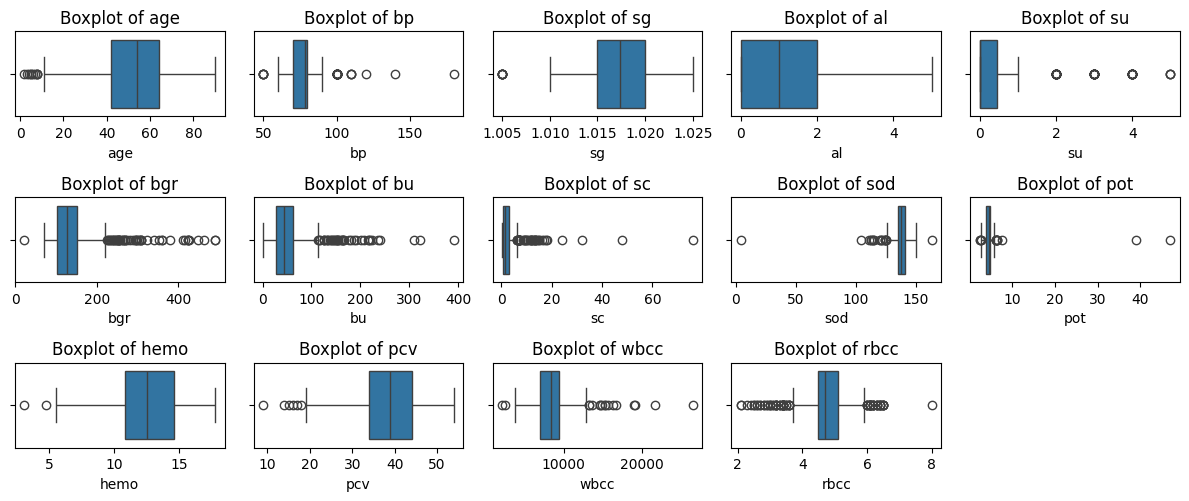

In [10]:
# Visualize boxplots for each numerical column
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [11]:
# Calculate IQR for each numerical column
Q1 = X[numerical_cols].quantile(0.25)
Q3 = X[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((X[numerical_cols] < lower_bound) | (X[numerical_cols] > upper_bound))

# Count outliers for each column
outlier_counts = outliers.sum()
print(outlier_counts)

age     10
bp      36
sg       7
al       0
su      48
bgr     53
bu      41
sc      44
sod     18
pot     14
hemo     2
pcv      6
wbcc    17
rbcc    75
dtype: int64


              age          bp          sg          al          su         bgr  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean    51.568376   75.719072    1.017452    1.016949    0.222685  136.985267   
std     16.748312   10.947479    0.005277    1.272318    0.400131   46.028992   
min      9.000000   55.000000    1.007500    0.000000    0.000000   27.500000   
25%     42.000000   70.000000    1.015000    0.000000    0.000000  101.000000   
50%     54.000000   78.234536    1.017408    1.000000    0.000000  126.000000   
75%     64.000000   80.000000    1.020000    2.000000    0.450142  150.000000   
max     90.000000   95.000000    1.025000    5.000000    1.125356  223.500000   

               bu          sc         sod         pot        hemo         pcv  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean    51.010409    2.254129  138.115004    4.432744   12.532937   38.946998   
std     30.261358    1.8612

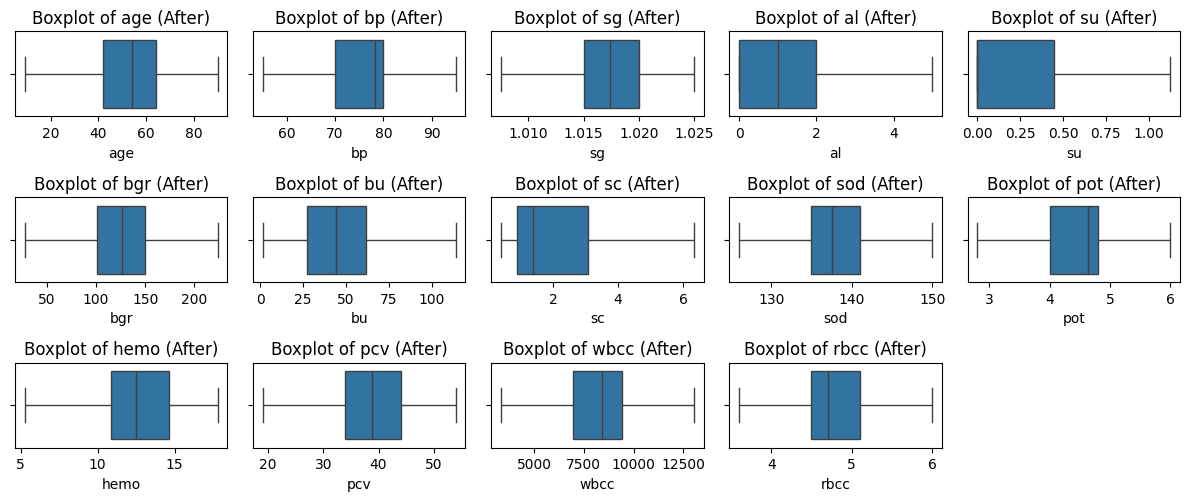

In [12]:
# Cap outliers to the lower and upper bounds in the original X
for col in numerical_cols:
    # Use .loc to safely modify the column values directly in X
    X.loc[:, col] = X[col].clip(lower=lower_bound[col], upper=upper_bound[col])

# Check the summary statistics of the capped data
print(X.describe())

# Visualize boxplots again after handling outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot of {col} (After)")
plt.tight_layout()
plt.show()



Data Encoding

Categorical variables are label encoded to convert them into numerical representations.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Ordinal Encoding for 'sg', 'al', 'su'
ordinal_cols = ['sg', 'al', 'su']
label_encoder = LabelEncoder()

for col in ordinal_cols:
    X.loc[:, col] = label_encoder.fit_transform(X[col])

# One-Hot Encoding for nominal columns
nominal_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
X = pd.get_dummies(X, columns=nominal_cols)

# Check the result
print(X.head())

    age    bp   sg   al   su         bgr    bu   sc         sod       pot  \
0  48.0  80.0  4.0  1.0  0.0  121.000000  36.0  1.2  137.528754  4.627244   
1   9.0  55.0  4.0  5.0  0.0  148.036517  18.0  0.8  137.528754  4.627244   
2  62.0  80.0  1.0  3.0  3.0  223.500000  53.0  1.8  137.528754  4.627244   
3  48.0  70.0  0.0  5.0  0.0  117.000000  56.0  3.8  126.000000  2.800000   
4  51.0  80.0  1.0  3.0  0.0  106.000000  26.0  1.4  137.528754  4.627244   

   ...  dm_no  dm_yes  cad_no  cad_yes  appet_good  appet_poor  pe_no  pe_yes  \
0  ...  False    True    True    False        True       False   True   False   
1  ...   True   False    True    False        True       False   True   False   
2  ...  False    True    True    False       False        True   True   False   
3  ...   True   False    True    False       False        True  False    True   
4  ...   True   False    True    False        True       False   True   False   

   ane_no  ane_yes  
0    True    False  
1    Tru

In [14]:
# Convert boolean columns to 1/0
X = X.astype(int)

# Check the result
print(X.head())



   age  bp  sg  al  su  bgr  bu  sc  sod  pot  ...  dm_no  dm_yes  cad_no  \
0   48  80   4   1   0  121  36   1  137    4  ...      0       1       1   
1    9  55   4   5   0  148  18   0  137    4  ...      1       0       1   
2   62  80   1   3   3  223  53   1  137    4  ...      0       1       1   
3   48  70   0   5   0  117  56   3  126    2  ...      1       0       1   
4   51  80   1   3   0  106  26   1  137    4  ...      1       0       1   

   cad_yes  appet_good  appet_poor  pe_no  pe_yes  ane_no  ane_yes  
0        0           1           0      1       0       1        0  
1        0           1           0      1       0       1        0  
2        0           0           1      1       0       0        1  
3        0           0           1      0       1       0        1  
4        0           1           0      1       0       1        0  

[5 rows x 35 columns]


Feature Scaling

Yeo-Johnson transformation reduces skewness, followed by standardization to scale features.

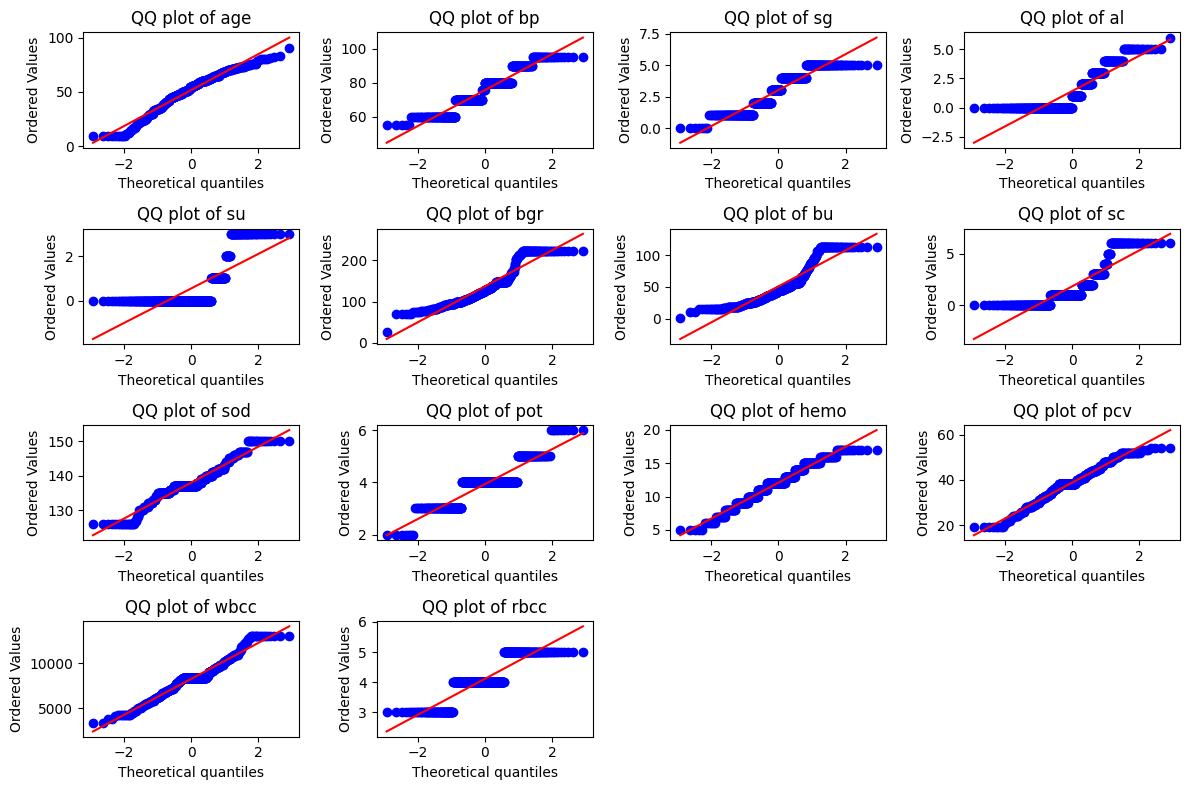

Skewness for the columns to standardize:
age    -0.607027
bp      0.089282
sg     -0.154466
al      0.819181
su      1.685293
bgr     0.717350
bu      0.920164
sc      1.143560
sod     0.078736
pot     0.229149
hemo   -0.285514
pcv    -0.274770
wbcc    0.199218
rbcc   -0.128594
dtype: float64


In [15]:
# Define the columns to standardize
columns_to_standardize = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
    'hemo', 'pcv', 'wbcc', 'rbcc'
]

# QQ plots for the columns to standardize
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_standardize, 1):
    plt.subplot(4, 4, i)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(f"QQ plot of {col}")
plt.tight_layout()
plt.show()

# Check skewness for the columns to standardize
skewness = X[columns_to_standardize].skew()
print(f"Skewness for the columns to standardize:\n{skewness}")


In [16]:
# Apply Yeo-Johnson transformation to the specified columns (in-place modification)
pt = PowerTransformer(method='yeo-johnson')

# Transform the selected columns in place
X[columns_to_standardize] = pt.fit_transform(X[columns_to_standardize])

# Check the skewness after Yeo-Johnson transformation
print("Skewness after Yeo-Johnson transformation:")
print(X[columns_to_standardize].skew())

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the transformed data (in-place modification)
X[columns_to_standardize] = scaler.fit_transform(X[columns_to_standardize])

# Check the summary statistics of the scaled data
print("\nSummary statistics of the scaled data:")
print(X[columns_to_standardize].describe())


Skewness after Yeo-Johnson transformation:
age    -0.190252
bp     -0.023060
sg     -0.184041
al      0.225515
su      1.028436
bgr    -0.000497
bu      0.000994
sc      0.050458
sod     0.002360
pot     0.021442
hemo   -0.061999
pcv    -0.048880
wbcc    0.005171
rbcc   -0.046682
dtype: float64

Summary statistics of the scaled data:
                age            bp            sg            al          su  \
count  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02  400.000000   
mean   5.329071e-17 -7.105427e-17 -3.552714e-17 -3.552714e-17    0.000000   
std    1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00    1.001252   
min   -2.126122e+00 -1.997318e+00 -2.055287e+00 -9.595094e-01   -0.614327   
25%   -6.678618e-01 -4.955340e-01 -6.603406e-01 -9.595094e-01   -0.614327   
50%    6.688288e-02  2.413739e-01  7.689316e-03  2.733458e-01   -0.614327   
75%    7.450324e-01  4.212497e-01  6.637806e-01  1.114875e+00    1.469760   
max    2.755096e+00  1.699223e+00  1.310512e+00 

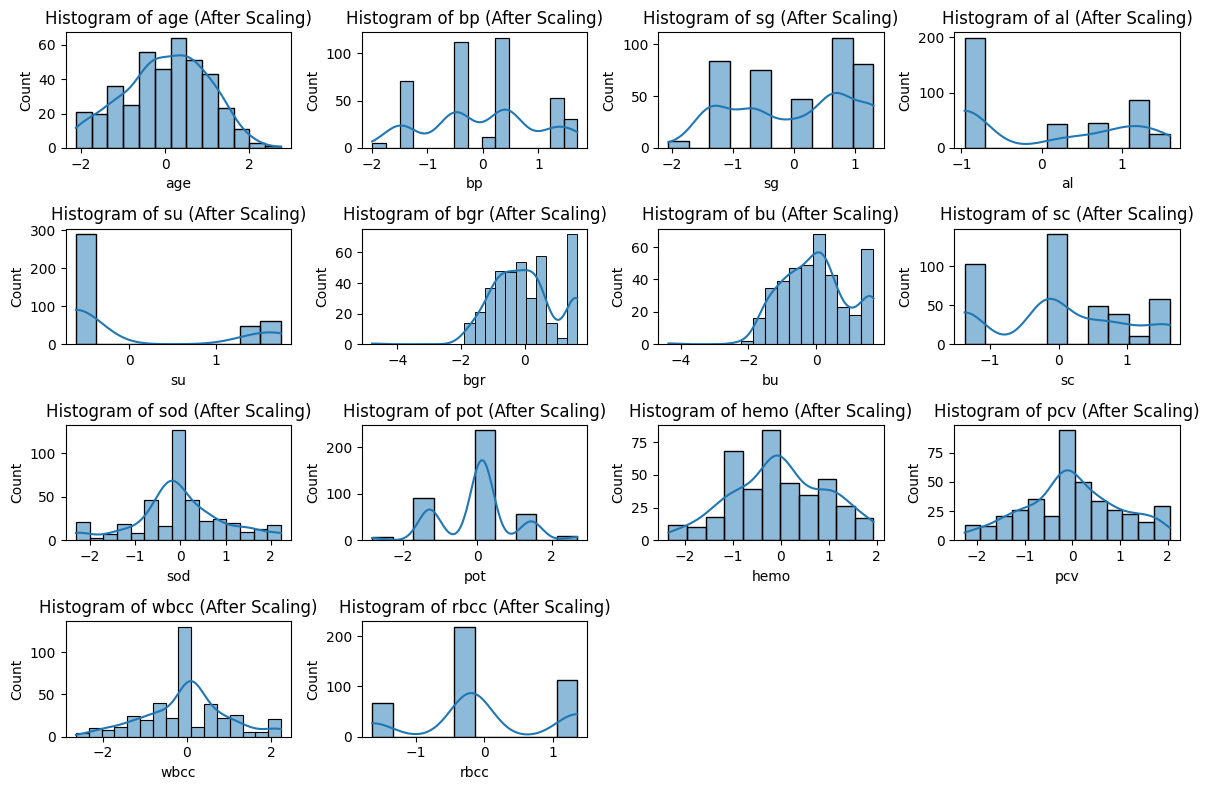

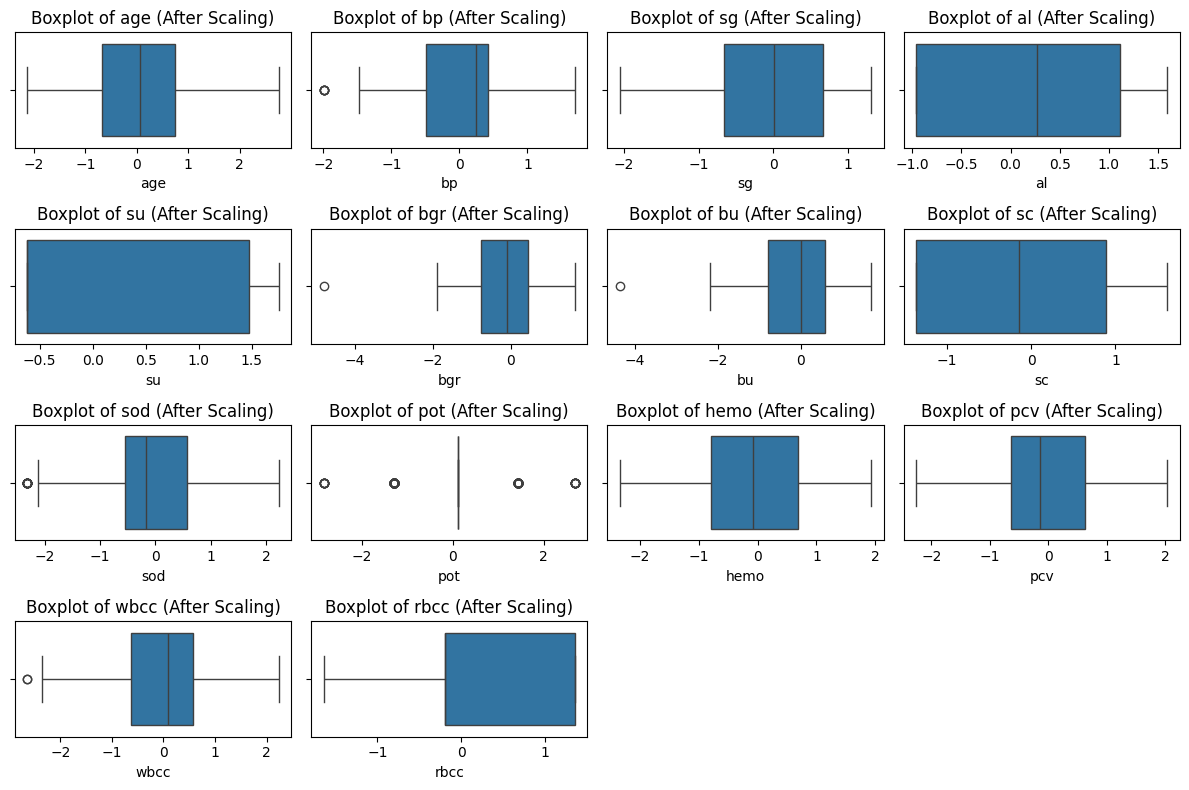

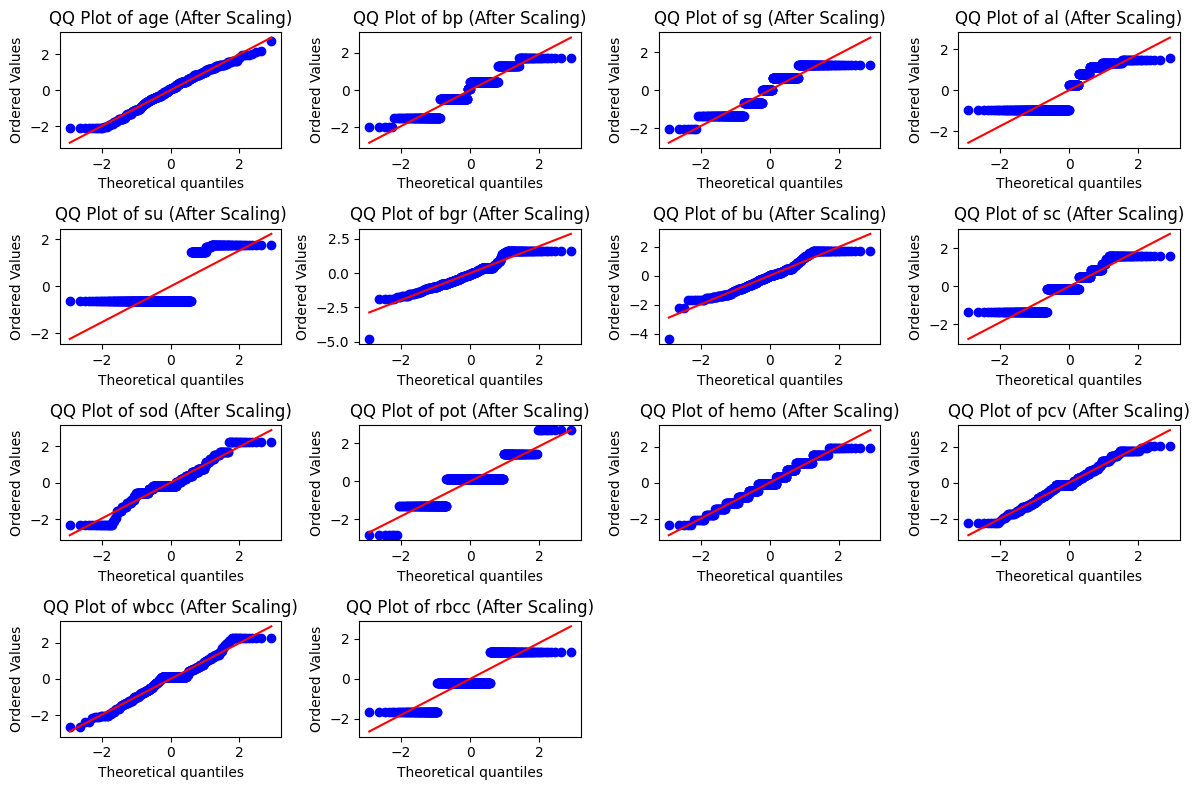

In [17]:
# Visualize histograms for the columns after Yeo-Johnson transformation and scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_standardize, 1):
    plt.subplot(4, 4, i)
    sns.histplot(X[col], kde=True)
    plt.title(f"Histogram of {col} (After Scaling)")
plt.tight_layout()
plt.show()

# Visualize boxplots after scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_standardize, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot of {col} (After Scaling)")
plt.tight_layout()
plt.show()

# Visualize QQ plots for the columns after scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_to_standardize, 1):
    plt.subplot(4, 4, i)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (After Scaling)")
plt.tight_layout()
plt.show()


In [18]:
# Check the data types of each column in the features DataFrame
data_types = X.dtypes
print("Data Types of Columns:\n", data_types)

# Separate columns into continuous and categorical types
continuous_cols = data_types[data_types != 'object'].index.tolist()  # continuous columns
categorical_cols = data_types[data_types == 'object'].index.tolist()  # categorical columns

print("\nContinuous Columns:", continuous_cols)
print("\nCategorical Columns:", categorical_cols)



Data Types of Columns:
 age               float64
bp                float64
sg                float64
al                float64
su                float64
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wbcc              float64
rbcc              float64
rbc_abnormal        int64
rbc_normal          int64
pc_abnormal         int64
pc_normal           int64
pcc_notpresent      int64
pcc_present         int64
ba_notpresent       int64
ba_present          int64
htn_no              int64
htn_yes             int64
dm_\tno             int64
dm_no               int64
dm_yes              int64
cad_no              int64
cad_yes             int64
appet_good          int64
appet_poor          int64
pe_no               int64
pe_yes              int64
ane_no              int64
ane_yes             int64
dtype: object

Continuous Columns: ['age', 'bp', 'sg', 'al', 'su',

Class Imbalance

['ckd' 'ckd\t' 'notckd']
['ckd' 'notckd']


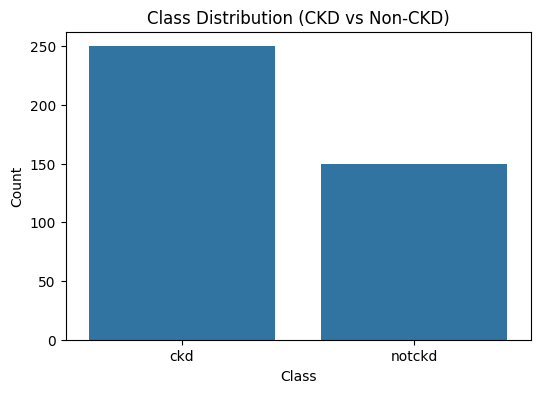

In [19]:
y = y.squeeze()

print(y.unique())
y = y.str.strip()

# After cleaning, check again
print(y.unique())

# Visualize the class distribution again
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution (CKD vs Non-CKD)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [20]:
# Calculate the total count of samples
total_count = len(y)

# Calculate the counts of each class
class_counts = y.value_counts()

# Calculate the percentages
percentage_ckd = (class_counts['ckd'] / total_count) * 100
percentage_not_ckd = (class_counts['notckd'] / total_count) * 100

# Display the results
print(f"Percentage of CKD: {percentage_ckd:.2f}%")
print(f"Percentage of Not CKD: {percentage_not_ckd:.2f}%")

Percentage of CKD: 62.50%
Percentage of Not CKD: 37.50%


Since the class distribution is not highly imbalanced (62.5% for CKD and 37.5% for Not CKD), I will proceed without addressing class imbalance for now.

The dataset is split into training and testing subsets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 320 samples
Testing set size: 80 samples


In [22]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


In [23]:
# Flatten y_train and y_test to ensure they are 1D arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

# Convert target labels to numerical (if not already done)
if not np.issubdtype(y_train.dtype, np.number):
    unique_classes = np.unique(y_train)
    class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
    y_train = np.array([class_mapping[label] for label in y_train])
    y_test = np.array([class_mapping[label] for label in y_test])
    print("Target classes mapped to:", class_mapping)


Target classes mapped to: {'ckd': 0, 'notckd': 1}


The neural network architecture is defined with an input layer corresponding to the number of features in the dataset. A hidden layer with 10 neurons is initialized with random weights and biases, and the output layer consists of one neuron for binary classification (CKD vs. not CKD).
Purpose: Establishes a foundational structure for the neural network to process input data and learn.

In [24]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Initialize parameters
input_layer_neurons = X_train.shape[1]
hidden_layer_neurons = 10
output_layer_neurons = 1

# Randomly initialize weights and biases
weights_input_hidden = np.random.randn(input_layer_neurons, hidden_layer_neurons)
bias_hidden = np.zeros((1, hidden_layer_neurons))

weights_hidden_output = np.random.randn(hidden_layer_neurons, output_layer_neurons)
bias_output = np.zeros((1, output_layer_neurons))

# Learning rate
learning_rate = 0.01


The activations for the hidden layer are calculated using
sigmoid(XW+b), where X is the input, W is the weights, and
b is the bias. The same sigmoid activation is applied to compute the output predictions.

In [25]:
def forward_propagation(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output):
    # Input to hidden layer
    hidden_input = np.dot(X, weights_input_hidden) + bias_hidden
    hidden_output = sigmoid(hidden_input)

    # Hidden to output layer
    output_input = np.dot(hidden_output, weights_hidden_output) + bias_output
    output = sigmoid(output_input)

    return hidden_output, output

The model computes the error between predictions and actual labels, adjusts weights, and updates biases. This involves:

Error computation at the output layer.
Backpropagating the error to the hidden layer.
Gradient updates using the sigmoid derivative to adjust the weights and biases iteratively.
Purpose: Refines the model parameters to minimize prediction errors.

In [26]:
def backpropagation(X, y, hidden_output, output, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, learning_rate):
    # Compute the error at the output layer
    error = y - output

    # Compute the gradient at the output layer (element-wise)
    d_output = error * sigmoid_derivative(output)

    # Compute the gradient at the hidden layer (propagate the error back)
    d_hidden = d_output.dot(weights_hidden_output.T) * sigmoid_derivative(hidden_output)

    # Update the weights and biases for the hidden-output layer
    weights_hidden_output += hidden_output.T.dot(d_output) * learning_rate
    bias_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate

    # Update the weights and biases for the input-hidden layer
    weights_input_hidden += X.T.dot(d_hidden) * learning_rate
    bias_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    return weights_input_hidden, bias_hidden, weights_hidden_output, bias_output


Forward propagation and backpropagation are performed over multiple epochs. The mean squared error is computed and printed periodically to monitor training progress.
Purpose: Enhances the network's performance by iteratively improving the weights and biases based on training data.

In [27]:
def train(X, y, epochs, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, learning_rate):
    for epoch in range(epochs):
        hidden_output, output = forward_propagation(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output)

        # Update weights and biases using backpropagation
        weights_input_hidden, bias_hidden, weights_hidden_output, bias_output = backpropagation(
            X, y, hidden_output, output, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, learning_rate)

        # Optional: Print error at every 100 epochs
        if epoch % 100 == 0:
            loss = np.mean(np.square(y - output))
            print(f"Epoch {epoch}, Loss: {loss}")

    return weights_input_hidden, bias_hidden, weights_hidden_output, bias_output

In [28]:
hidden_output, output = forward_propagation(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output)
print(f"Hidden Output Shape: {hidden_output.shape}")
print(f"Output Shape: {output.shape}")


Hidden Output Shape: (400, 10)
Output Shape: (400, 1)


In [29]:
y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1)


The model uses forward propagation on unseen data to generate predictions, thresholding them at 0.5 for binary classification.

In [30]:
def predict(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output):
    hidden_output, output = forward_propagation(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output)
    return (output > 0.5).astype(int)

Epoch 0, Loss: 0.4392587601245241
Epoch 100, Loss: 0.015433874841912049
Epoch 200, Loss: 0.007835454213514155
Epoch 300, Loss: 0.004786455347934554
Epoch 400, Loss: 0.003332358973542786
Epoch 500, Loss: 0.002520112771337995
Epoch 600, Loss: 0.002015800443207575
Epoch 700, Loss: 0.00167564207464891
Epoch 800, Loss: 0.0014313648532104553
Epoch 900, Loss: 0.0012475232458115126
Confusion Matrix:
[[50  2]
 [ 1 27]]


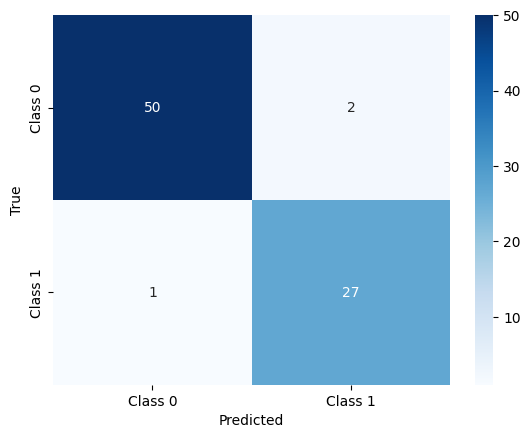

In [31]:
# Train the model
weights_input_hidden, bias_hidden, weights_hidden_output, bias_output = train(
    X_train, y_train, epochs=1000,
    weights_input_hidden=weights_input_hidden,
    bias_hidden=bias_hidden,
    weights_hidden_output=weights_hidden_output,
    bias_output=bias_output,
    learning_rate=learning_rate)

# Evaluate on test data
y_pred = predict(X_test, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(cm)


In [32]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.25%


Discuss the effects of the number of hidden layers neurons and standardizing the input attributes
on the classification accuracy.

To discuss the effects of the number of hidden layer neurons and standardizing the input attributes on classification accuracy, I'm going to analyze how these factors influence model performance using synthetic data, supported by visual comparisons and specific observations from the training results.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000,     # 1000 samples
                           n_features=20,      # 20 features
                           n_informative=15,   # 15 informative features
                           n_redundant=5,      # 5 redundant features
                           n_clusters_per_class=2,
                           random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [34]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Function to train the model with a given number of hidden neurons
def train_mlp(X_train, y_train, X_test, y_test, hidden_layer_neurons, epochs=1000, learning_rate=0.01):
    # Initialize parameters
    input_layer_neurons = X_train.shape[1]
    output_layer_neurons = 1

    # Randomly initialize weights and biases
    weights_input_hidden = np.random.randn(input_layer_neurons, hidden_layer_neurons)
    bias_hidden = np.zeros((1, hidden_layer_neurons))
    weights_hidden_output = np.random.randn(hidden_layer_neurons, output_layer_neurons)
    bias_output = np.zeros((1, output_layer_neurons))

    # Training loop
    for epoch in range(epochs):
        # Forward propagation
        hidden_layer_input = np.dot(X_train, weights_input_hidden) + bias_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)

        output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        predicted_output = sigmoid(output_layer_input)

        # Backpropagation
        error = y_train.reshape(-1, 1) - predicted_output
        d_predicted_output = error * sigmoid_derivative(predicted_output)

        error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

        # Update weights and biases
        weights_hidden_output += hidden_layer_output.T.dot(d_predicted_output) * learning_rate
        bias_output += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate

        weights_input_hidden += X_train.T.dot(d_hidden_layer) * learning_rate
        bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

    # Test prediction
    hidden_layer_input = np.dot(X_test, weights_input_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    predicted_output = sigmoid(output_layer_input)

    # Convert predictions to binary (0 or 1)
    predicted_output_binary = (predicted_output > 0.5).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted_output_binary)

    return accuracy


In [35]:
# List to store accuracy results for different hidden layer sizes
neuron_configs = [5, 10, 15, 20, 25, 30]  # Example hidden layer sizes
accuracies_non_standardized = []
accuracies_standardized = []

# Standardize the dataset
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Run experiments with non-standardized data
for neurons in neuron_configs:
    accuracy = train_mlp(X_train, y_train, X_test, y_test, hidden_layer_neurons=neurons)
    accuracies_non_standardized.append(accuracy)

# Run experiments with standardized data
for neurons in neuron_configs:
    accuracy = train_mlp(X_train_standardized, y_train, X_test_standardized, y_test, hidden_layer_neurons=neurons)
    accuracies_standardized.append(accuracy)


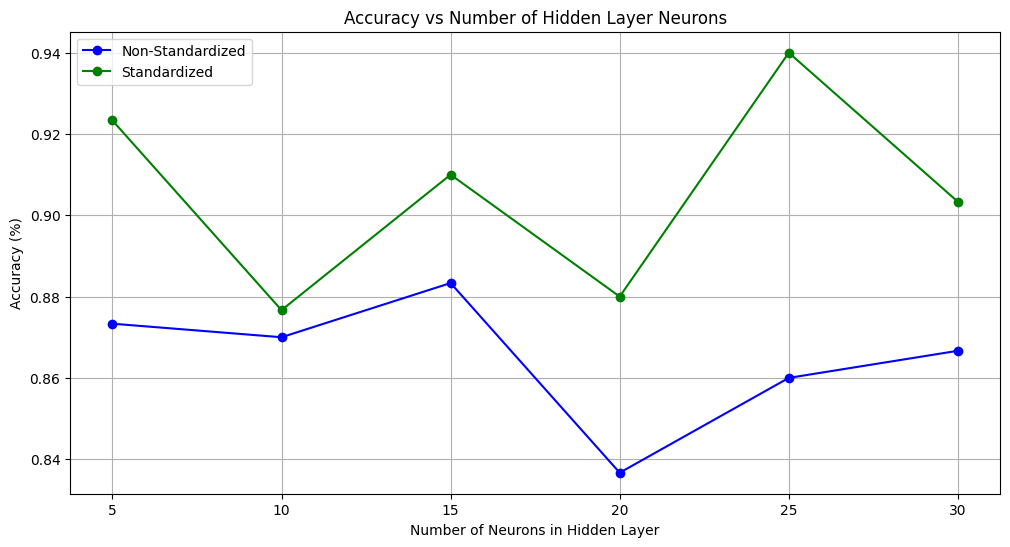

In [36]:
# Plot Accuracy vs Number of Hidden Layer Neurons for Non-Standardized Data
plt.figure(figsize=(12, 6))
plt.plot(neuron_configs, accuracies_non_standardized, marker='o', linestyle='-', color='b', label='Non-Standardized')
plt.plot(neuron_configs, accuracies_standardized, marker='o', linestyle='-', color='g', label='Standardized')
plt.title('Accuracy vs Number of Hidden Layer Neurons')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()


Standardized vs. Non-Standardized:

The standardized data consistently outperforms the non-standardized data in terms of classification accuracy. This indicates that standardizing input features (e.g., scaling them to have zero mean and unit variance) helps the neural network learn more effectively and improves performance.
For the standardized dataset (green line), the accuracy remains above 90% across all configurations, showing greater stability compared to the non-standardized dataset.
Impact of Hidden Layer Neurons:

Non-Standardized Data (Blue Line):
The accuracy tends to increase initially as the number of neurons grows from 5 to 10, indicating that a small increase in network capacity improves performance.
Beyond 10 neurons, accuracy begins to fluctuate, showing a decrease beyond 15 neurons, and continues to drop up to 30 neurons. This decline may be due to overfitting, where the model becomes too complex for the given dataset.
Standardized Data (Green Line):
Accuracy remains high (around 90-92%) for all neuron configurations, with slight variations. The peak accuracy occurs with 15 neurons, and it remains relatively stable, suggesting that the network's performance is less sensitive to changes in hidden layer size when data is standardized.
Interpretation:
Optimal Hidden Layer Size: For the non-standardized dataset, using around 10 hidden neurons seems to provide the best accuracy before overfitting occurs. For the standardized data, 15 neurons perform the best, though other configurations remain close in performance.
Importance of Standardization: Standardizing the input attributes not only improves the overall accuracy but also makes the training process more robust to the choice of hidden layer size. This is because standardization helps the network converge more effectively by ensuring that all features contribute equally to the learning process.
Conclusion:
Standardization is crucial for achieving higher and more stable accuracy in neural networks.
An optimal hidden layer size exists that balances model complexity and performance, with 10-15 neurons showing good performance for both datasets. However, standardization allows flexibility in this choice without significantly compromising accuracy.





